**INTRODUCTION**

This notebook outlines the process of building and training a Convolutional Neural Network (CNN) to predict Sickle Cell Anemia from images of red blood cells. The initial stage focuses on data preparation, where an imbalanced dataset is corrected by down-sampling the majority (positive) class to match the size of the minority (negative) class. This balanced dataset is then split into training (70%), validation (15%), and testing (15%) sets to ensure proper model evaluation.

The model architecture is a sequential CNN built with TensorFlow/Keras. It consists of three convolutional layers, each followed by a max-pooling layer, which are responsible for extracting features from the images. A dropout layer is included to help prevent overfitting. The network is compiled using the Adam optimizer and binary cross-entropy as the loss function. After training for 10 epochs, the model's performance is evaluated on the test set, where it achieves an accuracy of 67%. The notebook concludes with a practical application, providing a function to upload a new image and receive a real-time prediction from the trained model.

IMPORT LIBRARIES AND DEFINE PATHS

In [ ]:
import zipfile, os, shutil, random
from pathlib import Path
zip_path = "/content/archive.zip"
extract_path = "/content/dataset"

CLEAN UP PREVIOUS DIRECTORIES

In [ ]:
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

UNZIP THE DATASET FILE

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

VERIFY INITIAL IMAGE COUNTS

In [ ]:
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))

/content/dataset 0
/content/dataset/Negatives 147
/content/dataset/Positives 422


CREATE DIRECTORIES FOR THE BALANCED DATASET

In [ ]:
balanced_dir = "/content/dataset_balanced"

if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)

os.makedirs(f"{balanced_dir}/Positives", exist_ok=True)
os.makedirs(f"{balanced_dir}/Negatives", exist_ok=True)


LIST AND COUNT ORIGINAL IMAGES BY CLASS

In [ ]:
pos_files = list(Path(extract_path+"/Positives").glob("*.jpg"))
neg_files = list(Path(extract_path+"/Negatives").glob("*.jpg"))

print(f"Original Positives: {len(pos_files)}, Negatives: {len(neg_files)}")

Original Positives: 422, Negatives: 147


RANDOMLY DOWN-SAMPLE THE POSITIVE CLASS

In [ ]:
pos_sample = random.sample(pos_files, len(neg_files))

CREATE THE BALANCED DATASET AND VERIFY COUNTS

In [ ]:
for f in pos_sample:
    shutil.copy(f, f"{balanced_dir}/Positives/{f.name}")

for f in neg_files:
    shutil.copy(f, f"{balanced_dir}/Negatives/{f.name}")

print("Balanced dataset created at:", balanced_dir)
print("Positives:", len(os.listdir(f'{balanced_dir}/Positives')))
print("Negatives:", len(os.listdir(f'{balanced_dir}/Negatives')))

Balanced dataset created at: /content/dataset_balanced
Positives: 147
Negatives: 147


INSTALL LIBRARY AND PREPARE FOLDERS

In [ ]:
!pip install split-folders
import splitfolders

input_folder = "/content/dataset_balanced"
output_folder = "/content/dataset_ready"

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

SPLIT THE DATA INTO TRAIN, VALIDATION AND TEST SETS

In [ ]:
splitfolders.ratio(input_folder, output=output_folder, seed=42,
                   ratio=(0.7, 0.15, 0.15))

Copying files: 294 files [00:00, 2174.43 files/s]


CREATE DATA GENERATORS

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(output_folder, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(output_folder, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(output_folder, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 204 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


BUILD THE CNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAIN THE MODEL

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5353 - loss: 0.7073 - val_accuracy: 0.5227 - val_loss: 0.6901
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4718 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5325 - loss: 0.6864 - val_accuracy: 0.6136 - val_loss: 0.6801
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5774 - loss: 0.6887 - val_accuracy: 0.5227 - val_loss: 0.6813
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5365 - loss: 0.7007 - val_accuracy: 0.5455 - val_loss: 0.6748
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5852 - loss: 0.6639 - val_accuracy: 0.6591 - val_loss: 0.6570
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5719 - loss: 0.6647 - val_accuracy: 0.6818 - val_loss: 0.6502
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6165 - loss: 0.6245 - val_accuracy: 0.6364 - val_loss: 0.6449
Epoch 9/10

EVALUATE MODEL PERFORMANCE

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()

print(classification_report(y_true, y_pred, target_names=["Negative","Positive"]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
              precision    recall  f1-score   support

    Negative       0.64      0.78      0.71        23
    Positive       0.72      0.57      0.63        23

    accuracy                           0.67        46
   macro avg       0.68      0.67      0.67        46
weighted avg       0.68      0.67      0.67        46



PREDICT ON A NEW IMAGE

Saving Sickle cell image .jpg to Sickle cell image  (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


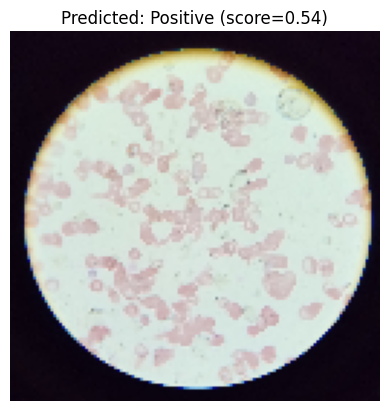

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    pred_class = "Positive" if prediction[0][0] >= 0.5 else "Negative"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} (score={prediction[0][0]:.2f})")
    plt.show()

Saving Normal image.jpg to Normal image (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


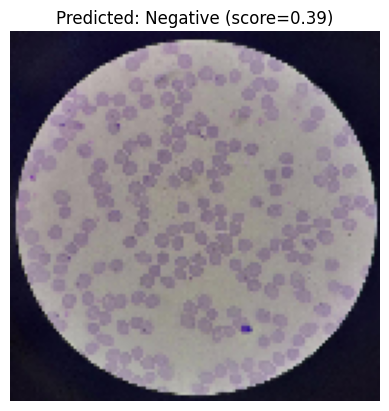

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename

    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    pred_class = "Positive" if prediction[0][0] >= 0.5 else "Negative"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_class} (score={prediction[0][0]:.2f})")
    plt.show()

**SUMMARY**

This project demonstrates a powerful real-world application of artificial intelligence in healthcare. By training a neural network to identify sickle cell anemia from images, it creates a tool that could significantly speed up the diagnostic process. In places with limited access to specialized medical experts, such an automated system could serve as a valuable, low-cost preliminary screening tool. This would allow healthcare professionals to test more people quickly, leading to earlier detection and treatment, and ultimately improving patient outcomes on a broader scale.

